<h1 align = center> CS156 </h1>

---
<h2 align = center> First Pipeline: Classifying Argentinian Accent </h2>

---
<h3 align = center> Prof. P. Watson </h3>
<h3 align = center> 23/02/2024 </h3>

---


### Problem Definition: Can a Machine Learning Model Identify Argentinian Accent?

Ever noticed how accents can make things interesting? They can be charming, surprising, or just plain cool. Think about all the different accents you've heard when you travel or move to a new place – British, Argentinian, Indian, and so on. After a while, all we've got left from these adventures are voice notes from local pals and some awesome memories. I've always been super into accents and got to thinking – could a machine learning model figure out an accent from a bunch of different ones?

The Task at Hand
For this assignement, I wanted to kick things off with something a bit more straightforward. Can a machine learning model spot the difference between one specific accent and a bunch of others? To make things a bit easier, I narrowed the problem to a specififc binary classification problem: Can a machine learning model tell an argentinian accent apart from other global accents?

Why It Matters
Getting a computer to tell which accent is which isn't just a cool party trick. It's got some serious uses in tech, like helping voice assistants understand us better, making subtitles more accurate, and even helping people learn languages. Plus, it's a stepping stone to getting machines to deal with all kinds of accents. Let's see if we can teach a machine to pick up on the Argentinian vibe, and who knows? Maybe it'll lead to some even bigger ideas down the line.

### 1: DATA COLLECTION
The data I am working with in this project are voice notes of my friends from Minerva and voice notes of my friends from Argentina. Although I had samples of voice notes from both the groups, I decided to collect this data again to make the data cleaning process easier for me. I asked my friends to send me one to three mins recordings of them reading a book or any news article in english. All the voice recordings from my argentian friends are thus my sample for argentinian accent and the voice recordings from Minervans serves as the other accent category.

This was convinient sampling as I asked a lot of my friends for the sample voice notes and used the recordings of people who sent them. In total, I had 4 samples (different people) of the argentinian accent and 7 samples of the other accent.

### 2 & 3: Data Pre-processing and Feature Engineering
I downloaded the files from my telegram and stored them in a folder in my computer. Then I renamed the audio files as Other1, Other2.. and Argentinian1, Argentinian2,.. and so on based on the accent class the audio file belonged to. 
Now, I needed to process these audio files into a format that can be read by python and also extract features of the audio that I can use as inputs for my ML models. I followed the following steps to acheive this task.

1. I wrote a python script to convert all my audio files into .wav format from the original .ogg format and then store those files in a new folder.

### Installing necessary libraries 

In [74]:
from pydub import AudioSegment
import os
os.environ['MKL_DEBUG_CPU_TYPE'] = '5' #hides unnecessary output
import subprocess
import seaborn as sns
from pydub import AudioSegment
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Python code to convert .ogg audio files to .wav from a source folder and store the new files in a target folder

In [75]:
# Replace the following path with the directory where ffprobe is located
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin/ffprobe'

# Quietly get the version of ffmpeg
subprocess.run(["ffmpeg", "-version"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

def convert_ogg_to_wav(source_folder, target_folder):
    # Ensure the source folder exists
    if not os.path.exists(source_folder):
        print(f"The folder {source_folder} does not exist.")
        return
    
    # Ensure the target folder exists, if not, create it
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        print(f"Created the folder {target_folder}.")

    # Scan the folder for .ogg files and convert each to .wav
    for filename in os.listdir(source_folder):
        if filename.endswith('.ogg'):
            ogg_path = os.path.join(source_folder, filename)
            # Change the wav_path to point to the target folder
            wav_path = os.path.join(target_folder, filename.replace('.ogg', '.wav'))
            
            # Load the .ogg audio file 
            audio = AudioSegment.from_ogg(ogg_path)
            
            # Export the audio file as .wav
            audio.export(wav_path, format="wav")
            # Commented out the print statement to suppress output
            # print(f"Converted {filename} to WAV.")

# Replace this with the path to the folder containing your .ogg files
source_folder = '/Users/shivamrawat/Desktop/OGGSAMPLES'
# Replace this with your desired target folder on the desktop
target_folder = '/Users/shivamrawat/Desktop/WAVSAMPLES'
convert_ogg_to_wav(source_folder, target_folder)

2. I wrote python script to split those audio clips into clips of 5 seconds each to maintain consistency in my sample and increase the sample size of my data as a sample size of 11 audio clips would be too small to train my model on. Any left over audio clip of less than 5 seconds is discarded and all the new 5 second audio clips are stored in a new folder. The audio clips are also named systematically, Other1 audio clip will be split into Other1_1, Other1_2, Other1_3 and so on. The same is true for the files names Argentinian.
### Python code to split the audio files into 5 seconds audio clips.

In [76]:
# Function to chop .wav files into 5-second clips
def chop_wav_to_subclips(source_folder, target_folder, clip_length_ms=5000):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Process each .wav file in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith('.wav'):
            wav_path = os.path.join(source_folder, filename)
            audio = AudioSegment.from_wav(wav_path)
            
            # Calculate the number of 5 second chunks
            n_chunks = len(audio) // clip_length_ms
            for i in range(n_chunks):
                # Calculate start and end times
                start_time = i * clip_length_ms
                end_time = start_time + clip_length_ms
                # Extract the subclip
                subclip = audio[start_time:end_time]
                # Format the subclip filename
                subclip_name = f"{filename[:-4]}_{i+1:02d}.wav"
                subclip_path = os.path.join(target_folder, subclip_name)
                # Export subclip
                subclip.export(subclip_path, format="wav")

# Specify source and target folders
source_folder = '/Users/shivamrawat/Desktop/WAVSAMPLES'  # Replace with your source folder path
target_folder = '/Users/shivamrawat/Desktop/AUDIOCLIPS'  # Replace with your target folder path

# Run the function
chop_wav_to_subclips(source_folder, target_folder)


3. I wrote python code that extarcts 6 audio features (See Appendix A for details) from each of the 5 second audio clips and then all that data is stored into a .csv file along with the name of the file and the class - Argentinian or Other. Librosa library is used to extract the audio features from the .wav files. 

The audio features selected measures different features of a sound like loudness, pitch, range of frequencies, melody, brightness etc., and since an accent is a distintive way of pronouncing a langauge I reasoned that these features can be used to classify accent given there can be differences in these features between accents.


### Python code to extract audio features from the audio clips and store them in a .csv file

In [77]:
import os
import pandas as pd
import librosa

def extract_features_to_csv(source_folder, target_folder, csv_filename):
    """
    Extract audio features from files in a source directory and save them to a CSV file.
    
    Parameters:
    - source_folder: Path to the folder containing audio files.
    - target_folder: Path to the folder where the CSV file will be saved.
    - csv_filename: Name of the CSV file to save the features to.
    
    Returns:
    - Full path to the saved CSV file.
    """
    # List to hold all feature vectors
    features_list = []

    # Process each file in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith('.wav'):  # Check if the file is a .wav file
            # Load the audio file
            audio_path = os.path.join(source_folder, filename)
            y, sr = librosa.load(audio_path)
            
            # Extract features using librosa
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
            rmse = librosa.feature.rms(y=y).mean()
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
            
            # Classify the file based on the filename
            file_class = 'Argentinian' if 'argentinian' in filename.lower() else 'Other'
            
            # Append the feature vector to the list
            features_list.append([filename, chroma_stft, spectral_centroid, spectral_bandwidth,
                                  spectral_rolloff, rmse, zero_crossing_rate, file_class])
    
    # Create a DataFrame from the features list
    features_df = pd.DataFrame(features_list, columns=['file_name', 'chroma_stft', 'spectral_centroid', 
                                                       'spectral_bandwidth', 'spectral_rolloff', 'rmse',
                                                       'zero_crossing_rate', 'class'])
    
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Save the DataFrame to a CSV file
    full_csv_path = os.path.join(target_folder, csv_filename)
    features_df.to_csv(full_csv_path, index=False)
    return full_csv_path

# File paths
source_folder = '/Users/shivamrawat/Desktop/AUDIOCLIPS'
target_folder = '/Users/shivamrawat/Desktop/AUDIODATA'
csv_filename = 'audio_featuresx.csv'

# Extract features and save to CSV
extracted_csv_path = extract_features_to_csv(source_folder, target_folder, csv_filename)
# Output the path to the saved CSV file

<img src = https://i.imgur.com/3CniJor.png\ width = "500" height = "500" > 
<div style='text-align: center;'>
  Figure 1: Sample image to show how audio features data is stored in the .csv file after extraction
</div

I also created a corrogram of the six features to see for collinearity. As we can see the the figure below, some of the features seem to be correlated. These consideration can be used for feature selection but for the first assignment I decided to ignore these nuances and will be doing think line PCA in the upcoming assignments. 
### Code to create the Corrogram

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/Users/shivamrawat/Desktop/AUDIODATA/audio_featuresx.csv')

# Assuming 'data' is your DataFrame and 'file_name' is the name of the column you want to remove
data = data.drop('file_name', axis=1)

# Map 'class' to colors
palette = {"Other": "orange", "Argentinian": "blue"}

# Draw the pairplot with the specified colors for the 'class' column
sns.pairplot(data, hue='class', palette=palette)

# Show the plot
plt.show()

<img src = https://i.imgur.com/C3L0H7m.png\ width = "500" height = "500" > 
<div style='text-align: center;'>
  Figure 2: Corrogram for the Audio features
</div

### 4: Discussing the task 
We can see based on the corrogram, there are places where we can draw a boundry between the two classes. So, I will be using a logistic regression to classify an audio clip into the category of either argentinian accent or other accent. "Other accent" here refers to any accent other than argentinian. To use a logistic regression for my model,

To train the machine learning model I divided my data from the audio_features.csv file into a training/testing class with a 75/25 split.

Note: Since the length of the intial audio samples were varible and I later split them into 5 second clips, there is a high probability that I have an unequal amounut of samples in the two classes. This can introduce bias in my model so to tackle this problem I used undersampling. Undersampling works by reducing the size of the majority class to match the minority class. This is done by randomly removing instances from the majority class, or by using more sophisticated methods that aim to retain as much information as possible, such as Tomek links or Centroid-Based Undersampling. In my code, I have implemented the simple undersampling method where the majority class samples are reduced to the minority class by random sampling.

### Python code to split the data into training and testing data and balance the two classes usign undersampling.

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset
data = pd.read_csv('/Users/shivamrawat/Desktop/AUDIODATA/audio_featuresx.csv')  # Replace with 
#the actual path to the CSV file
data = data.drop('file_name', axis=1)

# Ensure the 'Class' column exists and correct the column name if necessary
class_column = 'class'  # Replace with the actual name of the class column

if class_column not in data.columns:
    raise ValueError(f"The column {class_column} was not found in the DataFrame.")

# Prepare the data for logistic regression
X = data.drop(class_column, axis=1)  # Predictors
y = data[class_column].apply(lambda x: 1 if x == 'Argentinian' else 0)  # Binary classification

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                    y_resampled, test_size=0.20, random_state=42)

### 5: Model Selection - Logistic Regression

We can break down the math of predicting the binary class - argentinian accent vs. other - from audio features using logistic regression.

The aim of the logistic regression model is to return a probability of an event occuring (a sample audio belonging to the argentinian class in our model) based on some independent varibles like the audio features (X vector of audio features). So, let's say p(X) is a linear function that returns that probability, but since p(X) is a unbounded linear eqaution it cannot be in the range of 0 to 1, which is required for something to be expressed in terms of probabilities. 

To address this issue, we instead say that the log odds of the probability p(X) is a linear function, 
So,

\begin{equation}
\log(\frac{p(X)}{1-p(X)}) = b + w^T X
\end{equation}

Now we can solve for p(X),

\begin{equation}
p(X) = \frac{e^{(b + w^T X)}}{1+e^{(b + w^T X)}}
\end{equation}

In the model, we have two outcomes, Y = 1 is the accent is argentinian or Y = 0 if the accent is other and since we wrote this equation as the probability of sample audio belonging to the argentinian accent. We can write:

\begin{equation}
p(Y=1|X) = \frac{e^{(b + w^T X)}}{1+e^{(b + w^T X)}}
\end{equation}

In this equation,

p(Y=1|X): This denotes the probability that the dependent variable Y is equal to 1 (the event happens) given the predictors X. In the context of binary classification, this is the probability that a given observation falls into the positive class.

b: Represents the bias term, also known as the intercept in the logistic regression model. It's like the starting point before any features are considered.

w: A vector of weights corresponding to the features in X. These weights are coefficients that determine how much influence each feature has on the prediction.

$w^TX$ :The transpose of the weight vector w multiplied by the feature vector X represents the linear combination of the predictors. This is essentially a dot product that gives a single number for each observation.

$ \frac{e^{z}}{1+e^{z}} $
: This is the logistic (sigmoid) function itself. It takes the exponential transformation and normalizes it so that the output is between 0 and 1, suitable for probability interpretation. $z = (b + w^T X)$. The sigmoid function is S-shaped and can take any real-valued number from the linear combination of inputs and map it to a value between 0 and 1, providing the foundation for logistic regression to serve as a probability estimator in binary classification tasks.

Once, we have the classification eqautions as above we can predict the probabilty of an audio clip belonging to the argentinian class based on its audio features and classify the audio clip as it as one belonging to the argentinian accent if the probability is > 0.5.

The core of the learning step in logistic regression based ML is to find the values of weights and biases for the logistic regression equation. The logistic regression algorithm does so using maximum likelihood estimation method, that optimises the weights by minimising the difference in the predicted probabilities and actual values of Y in our data. 

### Loss funtion

The above mentioned difference is quantified using the loss function known as the binary cross-entropy loss, also known as the log loss. As mentioned before, it quantifies the difference between the predicted probabilities and the actual binary outcomes

For a set of observations $(x^{(i)}, y^{(i)})$, where $x^{(i)}$ are the features and $y^{(i)}$ is the binary target variable that takes the value 1 for the positive class and 0 for the negative class, the loss for a single observation is defined as:

\begin{equation}
L(y^{(i)}, p^{(i)}) = -\left[y^{(i)} \log(p^{(i)}) + (1 - y^{(i)}) \log(1 - p^{(i)})\right]
\end{equation}

where $p^{(i)}$ is the predicted probability of the observation $x^{(i)}$ being in the positive class, calculated using the logistic regression model, and $\log$ is the natural logarithm.

For the entire dataset, the loss function is the average of the individual losses over all observations:

\begin{equation}
J(\mathbf{w}) = -\frac{1}{m} \sum_{i=1}^{m} \left[y^{(i)} \log(p^{(i)}) + (1 - y^{(i)}) \log(1 - p^{(i)})\right]
\end{equation}

where $m$ is the total number of observations and $\mathbf{w}$ represents the parameters of the model (weights and bias). The goal of logistic regression is to find the parameters $\mathbf{w}$ that minimize this cost function. This is typically done using optimization algorithms such as gradient descent. By minimizing this loss, the model's parameters are adjusted to improve the accuracy of the predictions on the training data.


### 6: Model training, Cross-validation and Hyperparameter tuning

For the logistic regression model, I trained the model using the training data and then used grid search to tune the hyperparameters in the model and finally used k-fold cross validation with k = 20 to find the training accuracy of the data.

### Code for training the logistic regression model

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter = 1000)

model.fit(X_train, y_train)

150 150 38 38


### Code for doing Grid Search for Hyperparamter tuning 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Norm used in the penalization
    'solver': ['liblinear']  # Algorithm to use for optimization
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.7


### Implementation of k-fold Cross Validation

In [112]:
from sklearn.model_selection import KFold, cross_val_score

# Initialize a k-fold object
kf = KFold(n_splits=20, shuffle=True, random_state=42)

# Initialize the logistic regression model
# Hyperparameters
tuned_model = LogisticRegression(C = 10, penalty = 'l1',solver = "liblinear",max_iter=1000)

# Perform k-fold cross-validation
cv_scores = cross_val_score(tuned_model, X_resampled, y_resampled, cv=kf)

# Print the mean of the cross-validation scores
print("Mean cross-validation score:", cv_scores.mean())

Mean cross-validation score: 0.7294444444444445


### 7 & 8: Predictions and Performance metrics

The model performed better than I was expecting since the sample size of my intial data was not very big but I think chopping my audio clips into size of 5 seconds was able to overcome that limitation to an extent as 5 seconds in not too short of a time to capture the differences in audio features for different accents. 

After hyperparameter tuning I got a accuracy of 63% which is good in the sense that it means our model is not taking random guesses as that would have resulted in a accuracy of 50% given our test data was balanced for the two classes. Moreover, the recall and precision percentage of the model was also not very different, this indicates that the model is not biased towards one class. Right now, their is not much importance for the consideration of these metrics given i am not using this model for any real world application but in the case that this model is used in the real world for identifying multiple accents, it will be ideal to have an equal true positive and false positive rate for both classes as otherwise it can lead to biased results of a particular accent speaking group.

Given my model's result it is still very important to note that the representation of argentinian accent and other accents in my sample was very limited and it is high likely that my model is only good as classifying those subset of accents from each other and might perform worse when it is deployed in the real world. For ex, the four argentinian accent samples in my data were from people from Buenos Aires and as there are differences in accent of people in a country based on different regions, it is possible that the accuracy of my model might decrease id tested on those samples.

In [83]:
# Predict the test set
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65        19
           1       0.65      0.58      0.61        19

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.63      0.63      0.63        38



### Code for generating Confusion Matrix

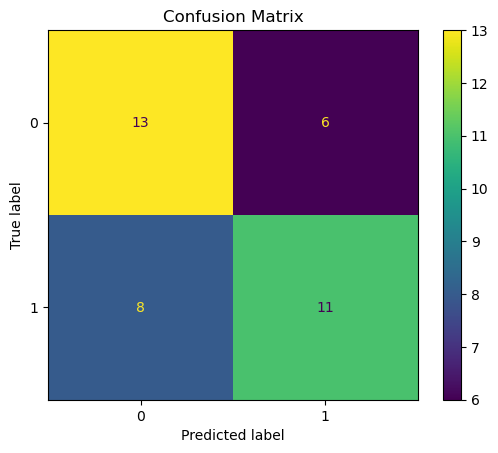

In [84]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and plot the confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model.classes_)
disp.plot()

plt.title('Confusion Matrix')
plt.show()

### Code for ROC curve

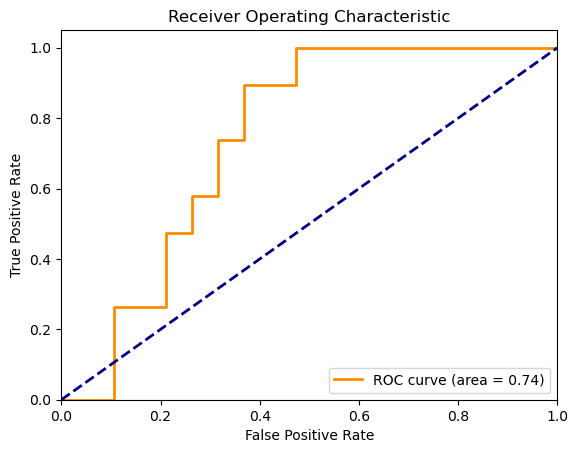

In [85]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Predict probabilities for the test set
y_probs = tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Repeating the process with Random forest

Just as an extension and for comparision, I also used a Random Forest model to do the classification task. A Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes from individual trees. It can be used for both classification and regression tasks.

I will be not going into the depths of random forest in this assignment as I have already used too much time on this assignemnt but based on the test results of using Random Forest I saw a huge increase in the accuracy of my model.

The test accuracy of the RF model was 82%, I am not entirely sure of the reason of this huge jump in accuracy but I think this can be because RF handle multicollinearity better than logistic regression and as we saw in the corrogram plot before their were some instances of multicollinearity that I intentionally ignored for this assignment.

In [86]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print("")

### Hyperparamter tuning for Random Forest Model

In [88]:
os.environ['MKL_DEBUG_CPU_TYPE'] = '5' #hides unnecessary output
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Assuming X_resampled and y_resampled are already defined and 
are your features and labels after undersampling

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]            # Method for sampling data points
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Score: 0.8187766714082503


### K-fold Cross-Validation for Random Forest Model

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming X_resampled and y_resampled are your features and labels after undersampling
# Initialize a k-fold object
kf = KFold(n_splits=20, shuffle=True, random_state=42)

# Initialize the RandomForestClassifier
rf_tuned_model = RandomForestClassifier(random_state=0, bootstrap = True, max_depth = 10, \
                                        min_samples_leaf = 1, min_samples_split = 2, n_estimators = 10)
# Perform 5-fold cross-validation

cv_scores = cross_val_score(rf_tuned_model, X_resampled, y_resampled, cv=kf,verbose = 0)

# Output the mean of the cross-validation scores
mean_cv_score = cv_scores.mean()

print(f'Mean CV Score: {mean_cv_score:.4f}')


Mean CV Score: 0.8344


In [99]:
# Predict the test set
rf_tuned_model.fit(X_train, y_train)
y_pred = rf_tuned_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        19
           1       0.88      0.74      0.80        19

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.81        38
weighted avg       0.82      0.82      0.81        38



### Confusion matrix for Random Forest Model

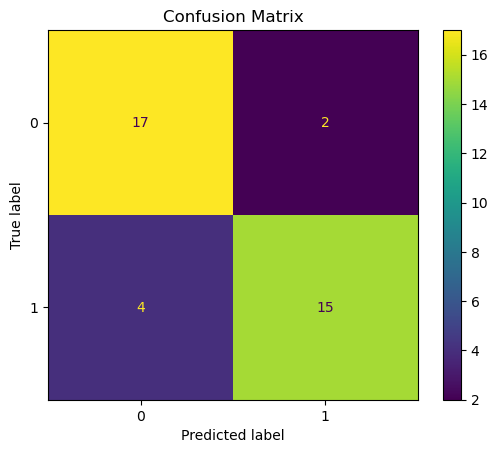

In [91]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create and plot the confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_tuned_model.classes_)
disp.plot()

plt.title('Confusion Matrix')
plt.show()

### ROC Curve for Random Forest

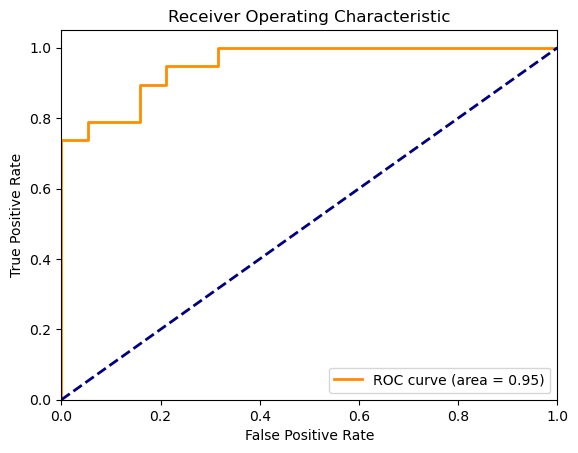

In [92]:
# Predict probabilities for the test set
y_probs = rf_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 9: Executive Summary
In this pipeline, I created a ML pipeline to distinguish between argentinian accent from any other accent from sample of audio clips collected from Minervans and native Argentinian people. Librosa library was used to extract 6 different audio features from the audio clips that served as the data for model training. I used two models in this assignment - logistic regression and random forest and found that random forest did significantly better than the logistic regression model (62 vs 82% test accuracy).

For the upcoming pipelines, I will spend more time on feature selection based on exploration of data to see how that can improve my results and also create synthetic data to create more training samples. I will be exloring more models like CNN in the upcoming assignments to see how well they perform for accent classification task.

<img src = https://i.imgur.com/Nq6w4DF.png\ width = "500" height = "500" > 
<div style='text-align: center;'>
  Figure 3: Simplified pre-processing and feature engineering pipeline
</div

### 10: References
Librosa. librosa. (n.d.). https://librosa.org/doc/latest/index.html 

M, R. A. (2019, July 5). Audio files to dataset by feature extraction with librosa. Medium. https://medium.com/@alexandro.ramr777/audio-files-to-dataset-by-feature-extraction-with-librosa-d87adafe5b64 

Pandita, S. (2021, May 29). Music genre classification using Random Forest. Medium. https://medium.com/hackerdawn/music-genre-classification-using-random-forest-219fc2446666 

Rai, K. (2020b, June 14). The math behind logistic regression. Medium. https://medium.com/analytics-vidhya/the-math-behind-logistic-regression-c2f04ca27bca

Random forests Leo Breiman and Adele Cutler. Random forests - classification description. (n.d.). https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm 

Tanuwidjaja, O. (2022, January 22). Get To Know Audio Feature Extraction in Python - Towards
Data Science. Medium. https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdae fe42





AI statement: I used AI to write, comment and provide docstrings for multiple instances of code I have used in this assignment but it is important to note that it was not always correct or gave the right output and to resolve that I read the documentation for libraries used to resolve any discrepancy and learn more about the code itself. I also used code to explain in a lot of terms and jargon I came across while doing this assignment. I also used AI for editing my paragraphs.

### Appendix A: Audio Features used in the model

1. Chroma STFT (Short-Time Fourier Transform): This feature represents the energy distribution of the audio signal over 12 different pitch classes (like the 12 different notes on a piano). It is often used in music to analyze the harmonic content.

2. Spectral Centroid: This is a measure that indicates where the "center of mass" of the spectrum is located. In simple terms, it gives a sense of the "brightness" of a sound, with higher values typically corresponding to "brighter" sounds with higher frequencies being more prominent.

3. Spectral Bandwidth: This refers to the width of the band of light from the spectrum that is emitted by the source. In audio analysis, it is often used to describe the range within which most of the energy of a sound is contained, which is indicative of the sound's "fullness."

4. Spectral Rolloff: This is a measure of the shape of the signal's spectrum. It represents the frequency below which a certain percentage of the total spectral energy, typically 85% to 95%, is contained. It can be used to distinguish between harmonic (musical) and noisy sounds.

5. RMSE (Root Mean Square Energy): This is a measure of the power or energy of the audio signal. Higher values mean the signal has more energy, and it's often associated with the loudness of the sound.

6. Zero Crossing Rate: This feature measures the rate at which the signal changes sign or "crosses zero." It is often indicative of the noisiness or the frequency content of the sound, with higher rates usually associated with more complex sounds like speech or music.

These features are calculated over short time frames and are often averaged (as shown in your code) to provide a single value that summarizes the feature over the entire audio clip. They provide a snapshot of different characteristics of the sound that can be used to classify or cluster audio recordings effectively.